# Project 5: Vehicle Detection and Tracking
## Joseph Rogers
## Udacity Self-Driving Car Nanodegree
This Jupyter Notebook contains all of the code necessary for traning a classifier and using it to perform vehicle detection on a video stream.

Much of the code for this project has been borrowed and adapted from the Udacity Self-Driving Car Nanodegree Vehicle Detection and Tracking lectures.

## 1) Perform some basic imports and set up starting parameters
Import all of the packages necessary to search the image for vehicles. Then print a test image of a sample frame to check work on.

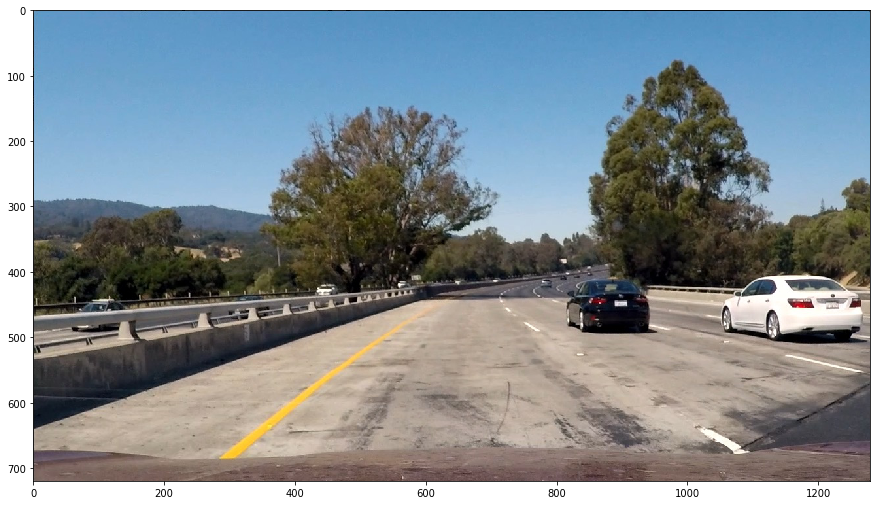

In [20]:
import pickle
import cv2
import time
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label

image = mpimg.imread('./test_images/test1.jpg')

plt.figure(figsize=(15,15))
plt.imshow(image)
plt.show()

## 2) Load the dataset and print some images
Load the dataset containing the labeled data for car and notcar objects. This data will be used later to train a linear SVM classifier.

Dataset contains 8792 car images and 8968 NOT car images


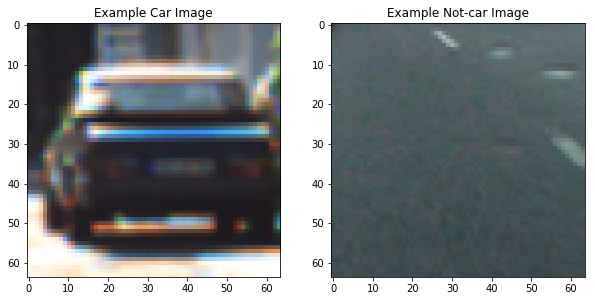

In [21]:
cars = []
notcars = []

# Get all of the car images
for filename in glob.iglob('./vehicles/vehicles/**/*.png', recursive=True):
    cars.append(filename)

# Get all of the notcar images
for filename in glob.iglob('./non-vehicles/non-vehicles/**/*.png', recursive=True):
    notcars.append(filename)

# Dataset stats
print("Dataset contains", len(cars), "car images and", len(notcars), "NOT car images")

car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))

# Read in car / not-car images
car_image = cv2.cvtColor(cv2.imread(cars[car_ind]), cv2.COLOR_BGR2RGB)
notcar_image = cv2.cvtColor(cv2.imread(notcars[notcar_ind]), cv2.COLOR_BGR2RGB)


# Plot an example of each type from the dataset
fig = plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Example Not-car Image')
plt.show()

## 3) Example HOG Visualization
Define a function for perform HOG feature extraction on images. Test that the function works by feeding it a sample image from the dataset.

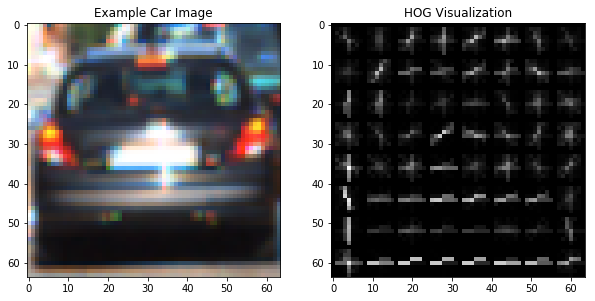

In [22]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features



    

# Generate a random index to look at a car image
ind = np.random.randint(0, len(cars))

example_image = cv2.cvtColor(cv2.imread(cars[ind]), cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(example_image, cv2.COLOR_RGB2GRAY)


# Define some test HOG parameters (May be different for the real pipeline)
orient = 12
pix_per_cell = 8
cell_per_block = 2
# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)


# Plot the examples
fig = plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(example_image, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')
plt.show()

## 4) Function for getting spacial features from image

In [23]:
# Define a function to compute binned color features 
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

## 5) Color Histogram features function
Basic histogram function for creating distict histogram feature for each color channel

In [24]:
# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

## 6) Extract Features Function
This function gather all image features, spacial, hist and HOG and then concatonate them together. The data returned is normalized to have a mean of 0.

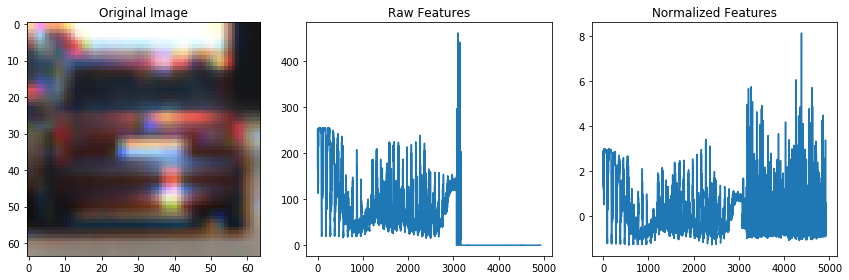

In [25]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = cv2.cvtColor(cv2.imread(file), cv2.COLOR_BGR2RGB)
        
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        
        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

car_features = extract_features(cars, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32)
notcar_features = extract_features(notcars, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32)



# Plot some of the data to see that it has been properly normalized
if len(car_features) > 0:
    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    car_ind = np.random.randint(0, len(cars))
    
    # Plot an example of raw and scaled features
    fig = plt.figure(figsize=(12,4))
    plt.subplot(131)
    plt.imshow(mpimg.imread(cars[car_ind]))
    plt.title('Original Image')
    plt.subplot(132)
    plt.plot(X[car_ind])
    plt.title('Raw Features')
    plt.subplot(133)
    plt.plot(scaled_X[car_ind])
    plt.title('Normalized Features')
    fig.tight_layout()
else: 
    print('Your function only returns empty feature vectors...')
    
plt.show()

## 7) Define function for drawing boxes
Simple function used to draw a series of boxes on an image

In [26]:
# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

print('done')

done


## 8) Slidine Window function
Function is used to take windows of a certain size and them slide them around a certain area of an image.

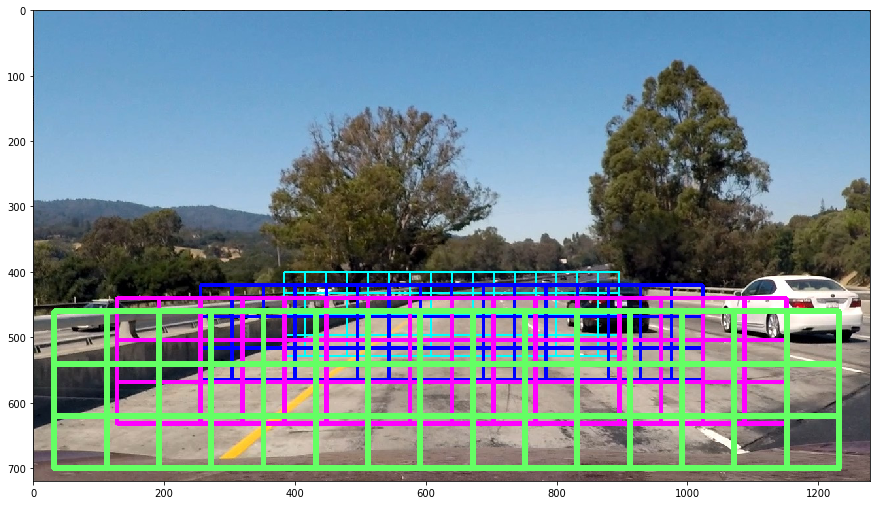

In [122]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list


# Demonstrate drawing windows in certain areas
# Pass 1
windows = slide_window(image, x_start_stop=[384, 896], y_start_stop=[400, 550], 
                    xy_window=[64, 64], xy_overlap=[0.5, 0.5])                    
window_img = draw_boxes(image, windows, color=(0, 255, 255), thick=2)    

# Pass 2
windows = slide_window(image, x_start_stop=[256, 1024], y_start_stop=[420, 600], 
                    xy_window=[96, 96], xy_overlap=[0.5, 0.5])                    
window_img = draw_boxes(window_img, windows, color=(0, 0, 255), thick=3)   

# Pass 3
windows = slide_window(image, x_start_stop=[128, 1152], y_start_stop=[440, 650], 
                    xy_window=[128, 128], xy_overlap=[0.5, 0.5])                    
window_img = draw_boxes(window_img, windows, color=(255, 0, 255), thick=5) 

# Pass 4
windows = slide_window(image, x_start_stop=[32, 1248], y_start_stop=[460, 720], 
                    xy_window=[160, 160], xy_overlap=[0.5, 0.5])                    
window_img = draw_boxes(window_img, windows, color=(100, 255, 100), thick=7) 



plt.figure(figsize=(15,15))
plt.imshow(window_img)
plt.show()

## 9) Color conversion function

In [78]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    
print('done')

done


## 10) Search Functions
These functions work together to search around an image and compare features to the database using the trained linear SVM classifier.

In [28]:
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows



print('done')



done


## 11) HOG Extration Parameters

In [29]:
# All of the options for extracting HOG features
color_space = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 10  # HOG orientations
pix_per_cell = 16 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16   # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

## 12) Extract the Spacial, Hist, and HOG features
Train a linear SVC using all of the extracted features from the training data.

In [30]:
# Get the HOG features for car and notcar
t = time.time()
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')


# Reshape features
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)


# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)



print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()

print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

57.97 Seconds to extract HOG features...
Using: 10 orientations 16 pixels per cell and 2 cells per block
Feature vector length: 1896
2.4 Seconds to train SVC...
Test Accuracy of SVC =  0.9944


## 13) Sub-sampling Window Search
Use a more efficient sub-sampling window search so that features don't have to be recalculated as often. Run the trained SVC on the test image and see where detections occur.

StandardScaler(copy=True, with_mean=True, with_std=True)
10
16
2
(16, 16)
16


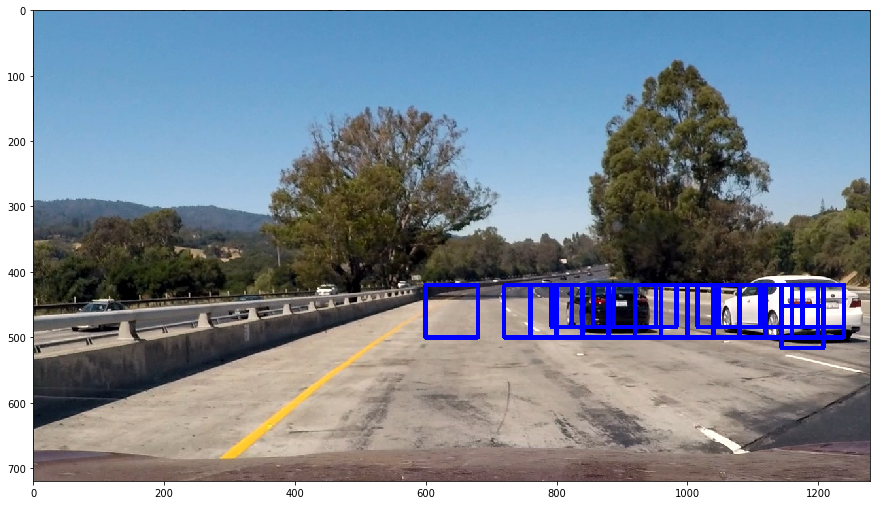

In [31]:
print(X_scaler)
print(orient)
print(pix_per_cell)
print(cell_per_block)
print(spatial_size)
print(hist_bins)


box_list = []

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, xstart, xstop, ystart, ystop, scale, cspace, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    box_list = []
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    # Slice out the section of the image to be inspected
    img_tosearch = img[ystart:ystop,xstart:xstop,:]
    
    
    # apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    else: ctrans_tosearch = np.copy(image)  
    
    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    
    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            temp_list = [0,0]
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            
            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            
            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                #cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6)
                cv2.rectangle(draw_img,(xbox_left+xstart, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6)

                
                #print((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart))
                #box_list.append(temp_list)
                box_list.append(((xbox_left+xstart, ytop_draw+ystart),(xbox_left+xstart+win_draw,ytop_draw+win_draw+ystart)))
                
    return box_list




#### Define some search passes and areas to search on the test image ####
xstart = 600
xstop = 1280
ystart = 420
ystop = 550
scale = 1
temp_box_list = find_cars(image, xstart, xstop, ystart, ystop, scale, color_space, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
for i in range(len(temp_box_list)):
    box_list.append(temp_box_list[i])
        
        
xstart = 600
xstop = 1280
ystart = 420
ystop = 550
scale = 1.25
temp_box_list = find_cars(image, xstart, xstop, ystart, ystop, scale, color_space, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
for i in range(len(temp_box_list)):
    box_list.append(temp_box_list[i])
    

xstart = 600
xstop = 1280
ystart = 420
ystop = 550
scale = 1.5
temp_box_list = find_cars(image, xstart, xstop, ystart, ystop, scale, color_space, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
for i in range(len(temp_box_list)):
    box_list.append(temp_box_list[i])


xstart = 600
xstop = 1280
ystart = 420
ystop = 560
scale = 2
temp_box_list = find_cars(image, xstart, xstop, ystart, ystop, scale, color_space, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
for i in range(len(temp_box_list)):
    box_list.append(temp_box_list[i])

    
# Plot the results of the seach passes
box_image = draw_boxes(image, box_list, color=(0, 0, 255), thick=6)
plt.figure(figsize=(15,15))
plt.imshow(box_image)
plt.show()

## 14) Test filtering multiple detections and false positives
Use a heat map with a threshold to filter out false positives in the detections and use multiple detections of the same features to reinforce certainty in good regions.

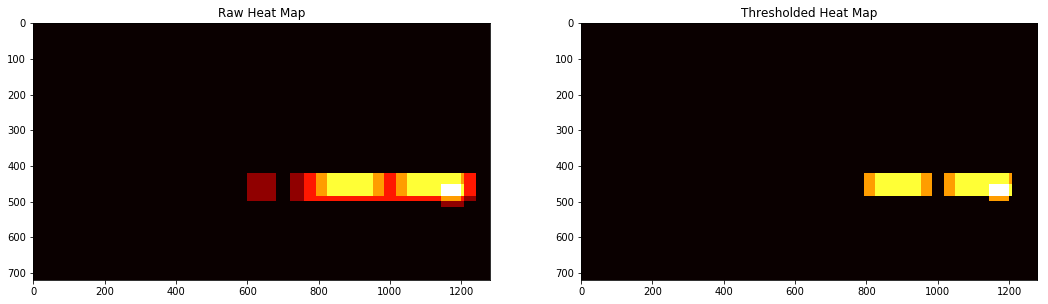

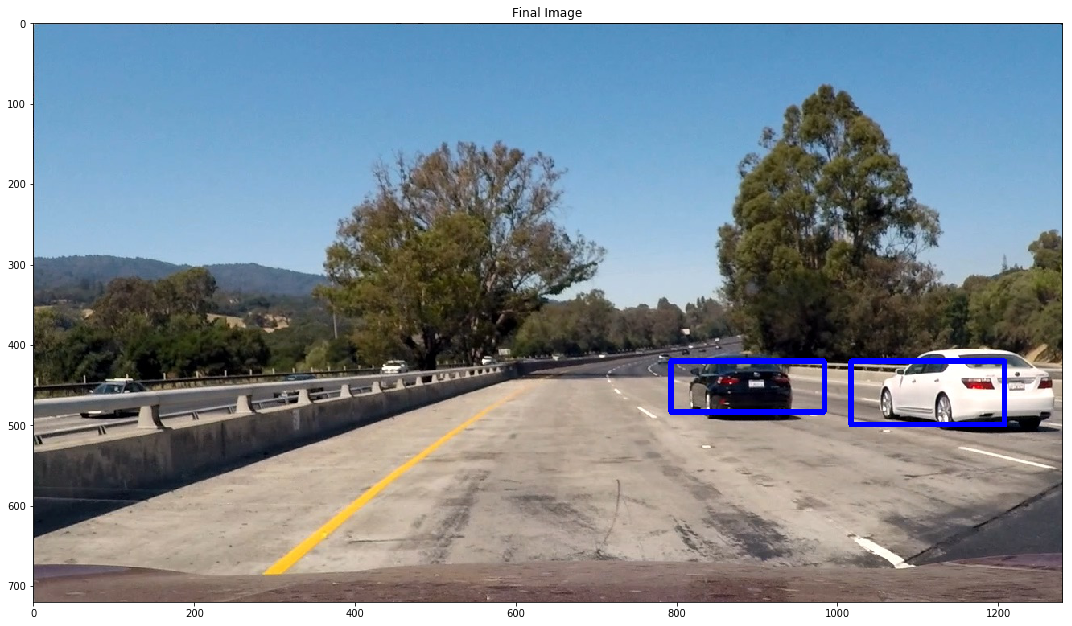

In [42]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap


def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0

    return heatmap


def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)

    return img

heat = np.zeros_like(image[:,:,0]).astype(np.float)
raw_heat = np.zeros_like(image[:,:,0]).astype(np.float)



# Add heat to each box in box list
raw_heat = add_heat(heat,box_list)
heat_img = np.copy(raw_heat)

    
# Apply threshold to help remove false positives
heat = apply_threshold(raw_heat,2)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
labels_img = draw_labeled_bboxes(np.copy(image), labels)


 # Plot an example of raw and scaled features
fig = plt.figure(figsize=(18,6))
plt.subplot(121)
plt.imshow(heat_img, cmap='hot')
plt.title('Raw Heat Map')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Thresholded Heat Map')

fig = plt.figure(figsize=(15,15))
plt.imshow(labels_img, cmap='hot')
plt.title('Final Image')
fig.tight_layout()

    

plt.show()

## 16) Vehicle Class to store data between frames
Define a classe that is able to save inter-frame data. This will allow detections from several frames to be smoothed together so that the final drawing of boxes is not as jumpy.

In [35]:
class Vehicle():
    def __init__(self):
        self.boxes = []
        self.all_boxes = []
        self.count = 0
        
    def update_boxes(self, new_boxes):
        self.all_boxes.append(new_boxes)
        
        # Keep 15 total frames of detection history
        if len(self.all_boxes) > 15:
            self.all_boxes = self.all_boxes[len(self.all_boxes) - 15:]
            
        # Only keep 8 frames of data in this list to actually be drawn
        if self.count % 8 == 0:
            self.boxes = self.all_boxes[len(self.all_boxes) - 8:]

## 17) Define Full Video Processing Pipeline
The whole function that the input video is passed to. This uses the trained SVC to grab detections from every frame of the video, update the class data and then create a heatmap before drawing the final computed boxed on the input image.

In [43]:
# New class object for testing purposes
detections = Vehicle()

def process_frame(image):
    
    # Keep a framecount to smoothout and avg data
    frame_count = detections.count
    
    
    # Re-declare all processing options
    color_space = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 10  # HOG orientations
    pix_per_cell = 16 # HOG pixels per cell
    cell_per_block = 2 # HOG cells per block
    hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
    spatial_size = (16, 16) # Spatial binning dimensions
    hist_bins = 16   # Number of histogram bins
    spatial_feat = True # Spatial features on or off
    hist_feat = True # Histogram features on or off
    hog_feat = True # HOG features on or off
    
    # New buffer for use in the heat calculations
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    # List to be used for gather currect frame detections
    box_list = []
    
    
    
    ### START OF ACTUAL SEARCHING FOR VEHICLES ###
    
    # Search Pass 1
    xstart = 600
    xstop = 1280
    ystart = 420
    ystop = 550
    scale = 1
    temp_box_list = find_cars(image, xstart, xstop, ystart, ystop, scale, color_space, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    for i in range(len(temp_box_list)):
        box_list.append(temp_box_list[i])
        
    # Search Pass 2
    xstart = 600
    xstop = 1280
    ystart = 420
    ystop = 550
    scale = 1.25
    temp_box_list = find_cars(image, xstart, xstop, ystart, ystop, scale, color_space, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    for i in range(len(temp_box_list)):
        box_list.append(temp_box_list[i])
    
    # Search Pass 3
    xstart = 600
    xstop = 1280
    ystart = 420
    ystop = 550
    scale = 1.5
    temp_box_list = find_cars(image, xstart, xstop, ystart, ystop, scale, color_space, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    for i in range(len(temp_box_list)):
        box_list.append(temp_box_list[i])

    # Search Pass 4
    xstart = 600
    xstop = 1280
    ystart = 420
    ystop = 560
    scale = 2
    temp_box_list = find_cars(image, xstart, xstop, ystart, ystop, scale, color_space, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    for i in range(len(temp_box_list)):
        box_list.append(temp_box_list[i])
        
    
    
    # Update detections for this frame
    detections.update_boxes(box_list)

    # Use data from the past frames to smooth out the heat
    for i in range(len(detections.boxes)):
        heat = add_heat(heat,detections.boxes[i])
    
    # Apply threshold to help remove false positives
    heatclamp = apply_threshold(heat, 5)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heatclamp, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    
    # Increment the frame count
    detections.count = detections.count + 1    
    result = draw_img

    return result


# Test the full pipeline on an image
#pipeline_test = process_frame(image)

#plt.figure(figsize=(15,15))
#plt.imshow(pipeline_test)
#plt.show()

## 18) Process Video Through Pipeline
Send the imput video through the processing function and save out a new video with the boxes now drawn on it.

In [ ]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import imageio
imageio.plugins.ffmpeg.download()
from moviepy.editor import *


# Make a new vehicle object to keep track of data
detections = Vehicle()


video_output = './output_images/project_video_test.mp4'
#video_clip = VideoFileClip('./test_video.mp4')
#video_clip = VideoFileClip('./project_video.mp4').subclip(30,40)
video_clip = VideoFileClip('./project_video.mp4')
video_clip = video_clip.fl_image(process_frame)
%time video_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video ./output_images/project_video_test.mp4
[MoviePy] Writing video ./output_images/project_video_test.mp4


 88%|████████▊ | 1110/1261 [02:20<00:23,  6.33it/s]